# Hypothesis Test

Here we'll analyze the [crimes](https://www.kaggle.com/dbwaller/official-crime-data-sao-paulo-statebrazil-ssp?fbclid=IwAR239ZovM1Zz3lIccXdxTuIHgaPB_G_YkI6G4HIXu4WUQWqC3Jz8Je3fU3o) in the State of São Paulo, Brazil, as well as its [GDP](https://www.seade.gov.br/produtos/pib-anual/). From these datasets we can try to check several things:

- The population increases in the same rate as the GDP?
- Are the GDP and Per Capita GDP similar?

But here we'll perform a t-test to check our hypothesis: 
 
<b>Hypothesis H1:</b> when a recession happens, the criminality increases.

If the p_value < 0.01 we reject the null hypothesis (H0), which means that the criminality stays the same, indepedent of recession periods.

Here, makes more sense to analyze the hypothesis with Per Capita GDP, but we'll perform both analysis. Also, ideally, the GDP should be in a monthly basis, not yearly. But due to the lack of data, we'll perform this analysis on a yearly basis.

Let's define recession, recession bottom, and end end of recession, which are only assumptions, as we'll see in the analysis:

- <b>Recession</b>: we consider a recession 2 consecutive years of negative growth, which ends with 2 consecutive years of GDP growth.
- <b>Recession bottom</b>: year with the lowest GDP.

$$ Recession Begin: GDP_{2010} > GDP_{2011} > GDP_{2012} $$

$$ Recession End: GDP_{2014} > GDP_{2013} > GDP_{2012} $$

$$ Recession Bottom: GDP_{2012} $$

Here some other definitions must be made. One should use the Real GDP as the parameter for this analysis, since it considers inflation. The GDP Growth Rate present in the table takes the Year of 2010 as a baseline. Here we'll compute the growht based in the yearly changes, not applying this baseline. so the Growth is calculated as follows:

$$ Growth Rate = \frac{(GDP_{Year+1} - GDP_{Year})}{GDP_{Year}} $$

The Growth Rate isn't necessary for this analysis, since we could perform it only with GDP values. However, they are easier to visualize due to smaller dimensions in comparison with GDP.

In [239]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import ttest_ind as ttest
import warnings as wn
%matplotlib inline

wn.filterwarnings('ignore')

In [199]:
gdp = pd.read_excel('PIB SP.xlsx')
crimes = pd.read_csv('SP Crimes.csv')

## GDP

GDP dataset has almost no work to be done. Here, our pipeline was quite simple:

1. Change columns' names and select importante features;
2. Calculate Growth Rates;
2. Check for missing values;
3. Check out for outliers;
4. Change "Year" to pandas datetime;

Since no values were missing, and the skewness of the dataset is approximately symmetric, we can proceed to the crimes dataset.

In [200]:
gdp.columns = ['Year','Nominal GDP (Mi)','Real GDP (Mi)','Base Year 2010','Growth Rate',
              'Deflator 2010 = 100perc','Population','Per Capita Nominal GDP',
              'Per Capita Real GDP','Per Capita Base Year 2010','Per Capita Growth Rate']
gdp = gdp[['Year','Real GDP (Mi)','Population','Per Capita Real GDP']]
gdp.head()

,Year,Real GDP (Mi),Population,Per Capita Real GDP
0,2002,518879.815172,37906414,13689.417353
1,2003,516263.912604,38340975,13465.070009
2,2004,628110.100885,38770813,16200.591432
3,2005,679181.007801,39201179,17325.525026
4,2006,771731.965749,39620277,19478.207226


In [201]:
gdp['Growth Rate'] = 0
gdp['Per Capita Growth Rate'] = 0
for i in range(0, gdp.shape[0]-1):
    gdp.iloc[i+1,4] = (gdp.iloc[i+1,1] - gdp.iloc[i,1])/gdp.iloc[i,1]
    gdp.iloc[i+1,5] = (gdp.iloc[i+1,3] - gdp.iloc[i,3])/gdp.iloc[i,3]
gdp.head()

,Year,Real GDP (Mi),Population,Per Capita Real GDP,Growth Rate,Per Capita Growth Rate
0,2002,518879.815172,37906414,13689.417353,0.000000,0.000000
1,2003,516263.912604,38340975,13465.070009,-0.005041,-0.016388
2,2004,628110.100885,38770813,16200.591432,0.216645,0.203157
3,2005,679181.007801,39201179,17325.525026,0.081309,0.069438
4,2006,771731.965749,39620277,19478.207226,0.136268,0.124249


In [202]:
gdp.isnull().sum()

Year                      0
Real GDP (Mi)             0
Population                0
Per Capita Real GDP       0
Growth Rate               0
Per Capita Growth Rate    0
dtype: int64

In [203]:
gdp.skew()

Year                      0.000000
Real GDP (Mi)             0.197298
Population               -0.120438
Per Capita Real GDP       0.133211
Growth Rate               0.322036
Per Capita Growth Rate    0.328771
dtype: float64

In [205]:
gdp['Year'] = pd.to_datetime(gdp['Year'], format='%Y')
gdp['Year'] = gdp['Year'].dt.year

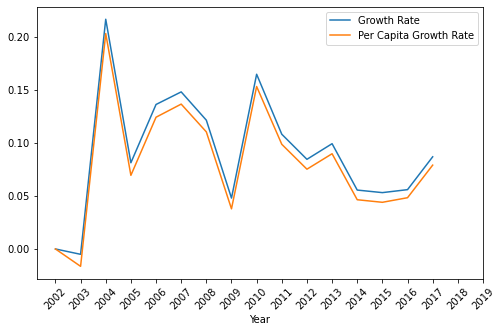

In [216]:
fig, ax = plt.subplots(figsize=(8,5))
gdp.plot(x='Year',y='Growth Rate', ax=ax)
gdp.plot(x='Year',y='Per Capita Growth Rate', ax=ax)
plt.xticks(gb['Year'].unique(), rotation=45);

## Crimes

On this dataset, our pipeline is a little more workfull, but follows almost the same line as above:

1. Replace and Change dtype: For the first step, if we try to convert the column to numeric, an error will be raised, since we have some strings in the middle of it ("..."). So we must replace them with NaN, and change columns to float;
2. GroupBy: Next, we group the "Total Crimes" by "Year", dropping 2001 since it has only NaN, and 2020, since it's incomplete. Here, we group by the sum of the crimes, not discretizing by type of crime.

In [189]:
crimes.columns = ['Nature','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug',
              'Sep','Oct','Nov','Dec','Total','Year','City','Region']
crimes.head()

,Nature,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Total,Year,City,Region
0,HOMICÍDIO DOLOSO (2),54.0,64.0,58.0,55.0,64.0,49,57,52,46,56,51,66,672.0,2018,São Paulo,Capital
1,Nº DE VÍTIMAS EM HOMICÍDIO DOLOSO (3),58.0,68.0,62.0,56.0,66.0,51,67,57,50,58,60,70,723.0,2018,São Paulo,Capital
2,HOMICÍDIO DOLOSO POR ACIDENTE DE TRÂNSITO,1.0,0.0,2.0,2.0,2.0,1,0,0,1,2,0,1,12.0,2018,São Paulo,Capital
3,Nº DE VÍTIMAS EM HOMICÍDIO DOLOSO POR ACIDENTE...,1.0,0.0,2.0,2.0,2.0,1,0,0,1,2,0,1,12.0,2018,São Paulo,Capital
4,HOMICÍDIO CULPOSO POR ACIDENTE DE TRÂNSITO,26.0,27.0,33.0,37.0,26.0,33,28,38,34,36,32,42,392.0,2018,São Paulo,Capital


In [190]:
crimes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249563 entries, 0 to 249562
Data columns (total 17 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Nature  248918 non-null  object 
 1   Jan     248321 non-null  float64
 2   Feb     248321 non-null  float64
 3   Mar     248321 non-null  float64
 4   Apr     248321 non-null  float64
 5   May     248321 non-null  float64
 6   Jun     248321 non-null  object 
 7   Jul     248321 non-null  object 
 8   Aug     248321 non-null  object 
 9   Sep     248321 non-null  object 
 10  Oct     248321 non-null  object 
 11  Nov     248321 non-null  object 
 12  Dec     248321 non-null  object 
 13  Total   248918 non-null  float64
 14  Year    249563 non-null  int64  
 15  City    249563 non-null  object 
 16  Region  249563 non-null  object 
dtypes: float64(6), int64(1), object(10)
memory usage: 32.4+ MB


In [191]:
crimes = crimes.replace('...', np.nan)

crimes.Jun = crimes.Jun.astype(float)
crimes.Jul = crimes.Jul.astype(float)
crimes.Aug = crimes.Aug.astype(float)
crimes.Sep = crimes.Sep.astype(float)
crimes.Oct = crimes.Oct.astype(float)
crimes.Nov = crimes.Nov.astype(float)
crimes.Dec = crimes.Dec.astype(float)

In [192]:
crimes['Year'] = pd.to_datetime(crimes['Year'], format='%Y')
crimes['Year'] = crimes['Year'].dt.year

In [193]:
gb = pd.DataFrame(crimes.groupby(['Year'])['Total'].sum().to_list(), 
        index = crimes.groupby(['Year'])['Total'].sum().index)
gb = gb.reset_index()
gb.columns=['Year','Crimes']
gb = gb[1:-1] # Year 2001 has only NaN values, and 2020 is incomplete
gb.head() 

,Year,Crimes
1,2002,1189115.0
2,2003,1264184.0
3,2004,1276930.0
4,2005,1304267.0
5,2006,1265711.0


In [194]:
gb.skew()

Year      0.000000
Crimes    0.410229
dtype: float64

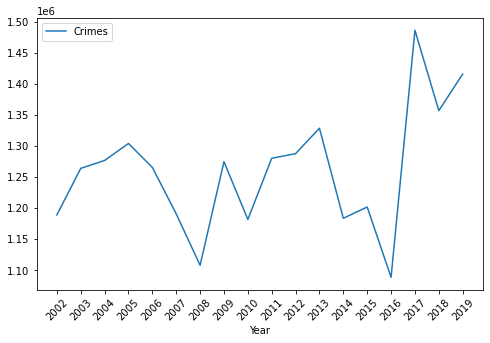

In [217]:
fig, ax = plt.subplots(figsize=(8,5))
gb.plot(x='Year',y='Crimes', ax=ax)
plt.xticks(gb['Year'].unique(), rotation=45);

## Merge

Let's **merge** the dataframes to ease the operations afterwards. As we can see above, since *Growth Rate* and *Per Capita Growth Rate* have the same trend, we can perform the *t-test* only over one parameter, in this case, *Growth Rate*.

In [196]:
df = gb.merge(gdp, on='Year')
df

,Year,Crimes,Real GDP (Mi),Population,Per Capita Real GDP,Growth Rate,Per Capita Growth Rate
0,2002,1189115.0,5.188798e+05,37906414,13689.417353,0.000000,0.000000
1,2003,1264184.0,5.162639e+05,38340975,13465.070009,-0.005041,-0.016388
2,2004,1276930.0,6.281101e+05,38770813,16200.591432,0.216645,0.203157
3,2005,1304267.0,6.791810e+05,39201179,17325.525026,0.081309,0.069438
4,2006,1265711.0,7.717320e+05,39620277,19478.207226,0.136268,0.124249
5,2007,1190838.0,8.860577e+05,40021813,22139.369899,0.148142,0.136623
6,2008,1107946.0,9.936740e+05,40419786,24583.850410,0.121455,0.110413
7,2009,1274979.0,1.041369e+06,40815076,25514.327130,0.047999,0.037849
8,2010,1181778.0,1.212954e+06,41223683,29423.723703,0.164769,0.153224
9,2011,1280425.0,1.344202e+06,41579695,32328.337239,0.108205,0.098717


In [227]:
def recession_begin():
    recession_begin = []
    for i in range(2, df.shape[0]):
        if df.iloc[i,5] < df.iloc[i-1,5] and df.iloc[i-1,5] < df.iloc[i-2,5]:
            if df.iloc[i+2,5] > df.iloc[i+1,5] and df.iloc[i+1,5] > df.iloc[i,5]:
                print('Year when Recession Began: ',df.iloc[i-2,0])

recession_begin()

Year when Recession Began:  2013


In [220]:
def recession_bottom():
    recession_begin = []
    for i in range(2, df.shape[0]):
        if df.iloc[i,5] < df.iloc[i-1,5] and df.iloc[i-1,5] < df.iloc[i-2,5]:
            if df.iloc[i+2,5] > df.iloc[i+1,5] and df.iloc[i+1,5] > df.iloc[i,5]:
                print('Year of Recession Bottom: ',df.iloc[i,0])
            
recession_bottom()

Year of Recession Bottom:  2015


In [226]:
def recession_end():
    recession_begin = []
    for i in range(0, df.shape[0]-2):
        if df.iloc[i,5] < df.iloc[i-1,5] and df.iloc[i-1,5] < df.iloc[i-2,5]:      
            if df.iloc[i+2,5] > df.iloc[i+1,5] and df.iloc[i+1,5] > df.iloc[i,5]:
                print(df.iloc[i+2,0])
            
recession_end()

2017


In [225]:
recession = df.query('(Year >= 2013) and (Year <= 2017)')
recession

,Year,Crimes,Real GDP (Mi),Population,Per Capita Real GDP,Growth Rate,Per Capita Growth Rate
11,2013,1328910.0,1.602592e+06,42304694,37882.121215,0.099284,0.089808
12,2014,1183699.0,1.691613e+06,42673386,39640.926921,0.055548,0.046428
13,2015,1201871.0,1.781510e+06,43046555,41385.648107,0.053143,0.044013
14,2016,1088491.0,1.881175e+06,43359005,43386.027369,0.055944,0.048335
15,2017,1486822.0,2.044693e+06,43674533,46816.588996,0.086923,0.079071


In [238]:
no_recession = df.merge(recession, how='outer', indicator='i').query('i == "left_only"').drop('i',1)
no_recession

,Year,Crimes,Real GDP (Mi),Population,Per Capita Real GDP,Growth Rate,Per Capita Growth Rate
0,2002,1189115.0,5.188798e+05,37906414,13689.417353,0.000000,0.000000
1,2003,1264184.0,5.162639e+05,38340975,13465.070009,-0.005041,-0.016388
2,2004,1276930.0,6.281101e+05,38770813,16200.591432,0.216645,0.203157
3,2005,1304267.0,6.791810e+05,39201179,17325.525026,0.081309,0.069438
4,2006,1265711.0,7.717320e+05,39620277,19478.207226,0.136268,0.124249
5,2007,1190838.0,8.860577e+05,40021813,22139.369899,0.148142,0.136623
6,2008,1107946.0,9.936740e+05,40419786,24583.850410,0.121455,0.110413
7,2009,1274979.0,1.041369e+06,40815076,25514.327130,0.047999,0.037849
8,2010,1181778.0,1.212954e+06,41223683,29423.723703,0.164769,0.153224
9,2011,1280425.0,1.344202e+06,41579695,32328.337239,0.108205,0.098717


### t-test

Now we perform our t-test observing two independent samples from the same population (recession and no recession), and measure whether the average (expected) value differs significantly across samples [[1]](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html).

As we can see, our $p_{value}$ for a one-sided test was <b>0.359</b>. Applying an $\alpha$ of 0.05, this results says that we should not reject our null hypothesis, which means that <i>the crimes don't differ significantly regarding the recession</i>.

In [242]:
recession_crimes = recession['Crimes'].to_list()
no_recession_crimes = no_recession['Crimes'].to_list()

In [248]:
print('p_value of', round(ttest(recession_crimes, no_recession_crimes)[1]/2,3))

p_value of 0.359
